In [5]:
import numpy as np
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2
""" Controls for figure sizes to change """
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams.update({'errorbar.capsize': 1})

from train import *
from utils import *
from networks import *

from SelectMultipleInteract import SelectMultipleInteract

args = parser.parse_args("")
# query if we have GPU
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda:1


Select models (all by default)

In [6]:
data_folders=[] # will be updated when selection is changed
SelectMultipleInteract(data_folders)

SelectMultipleInteract(children=(SelectMultiple(description='Models', index=(0, 1), options=('2022-04-18 21:49…

Load models and data trained in `cnn_train.ipynb`:
- model with lr=1.0
- model with lr=0.5

Learning rate was estimated in `range_test.ipynb`

In [7]:
models, results, model_titles = load_models_and_params(data_folders, device)

## Training history

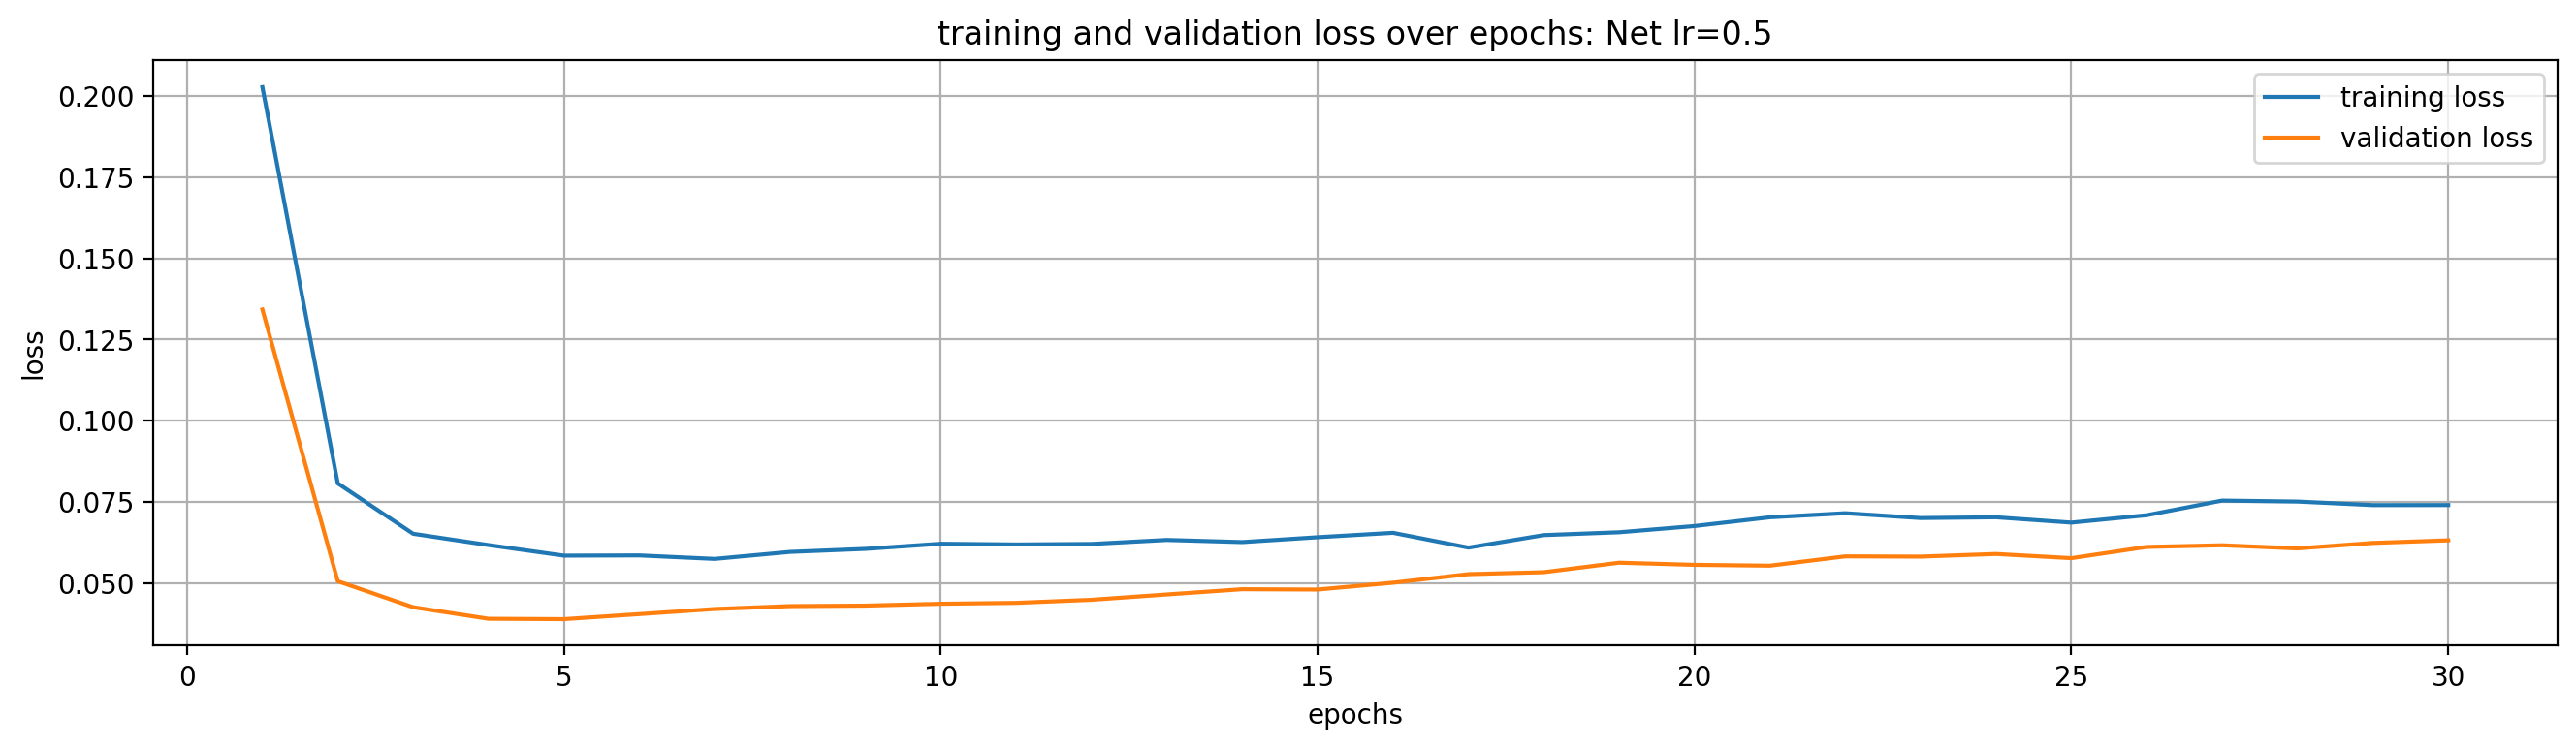

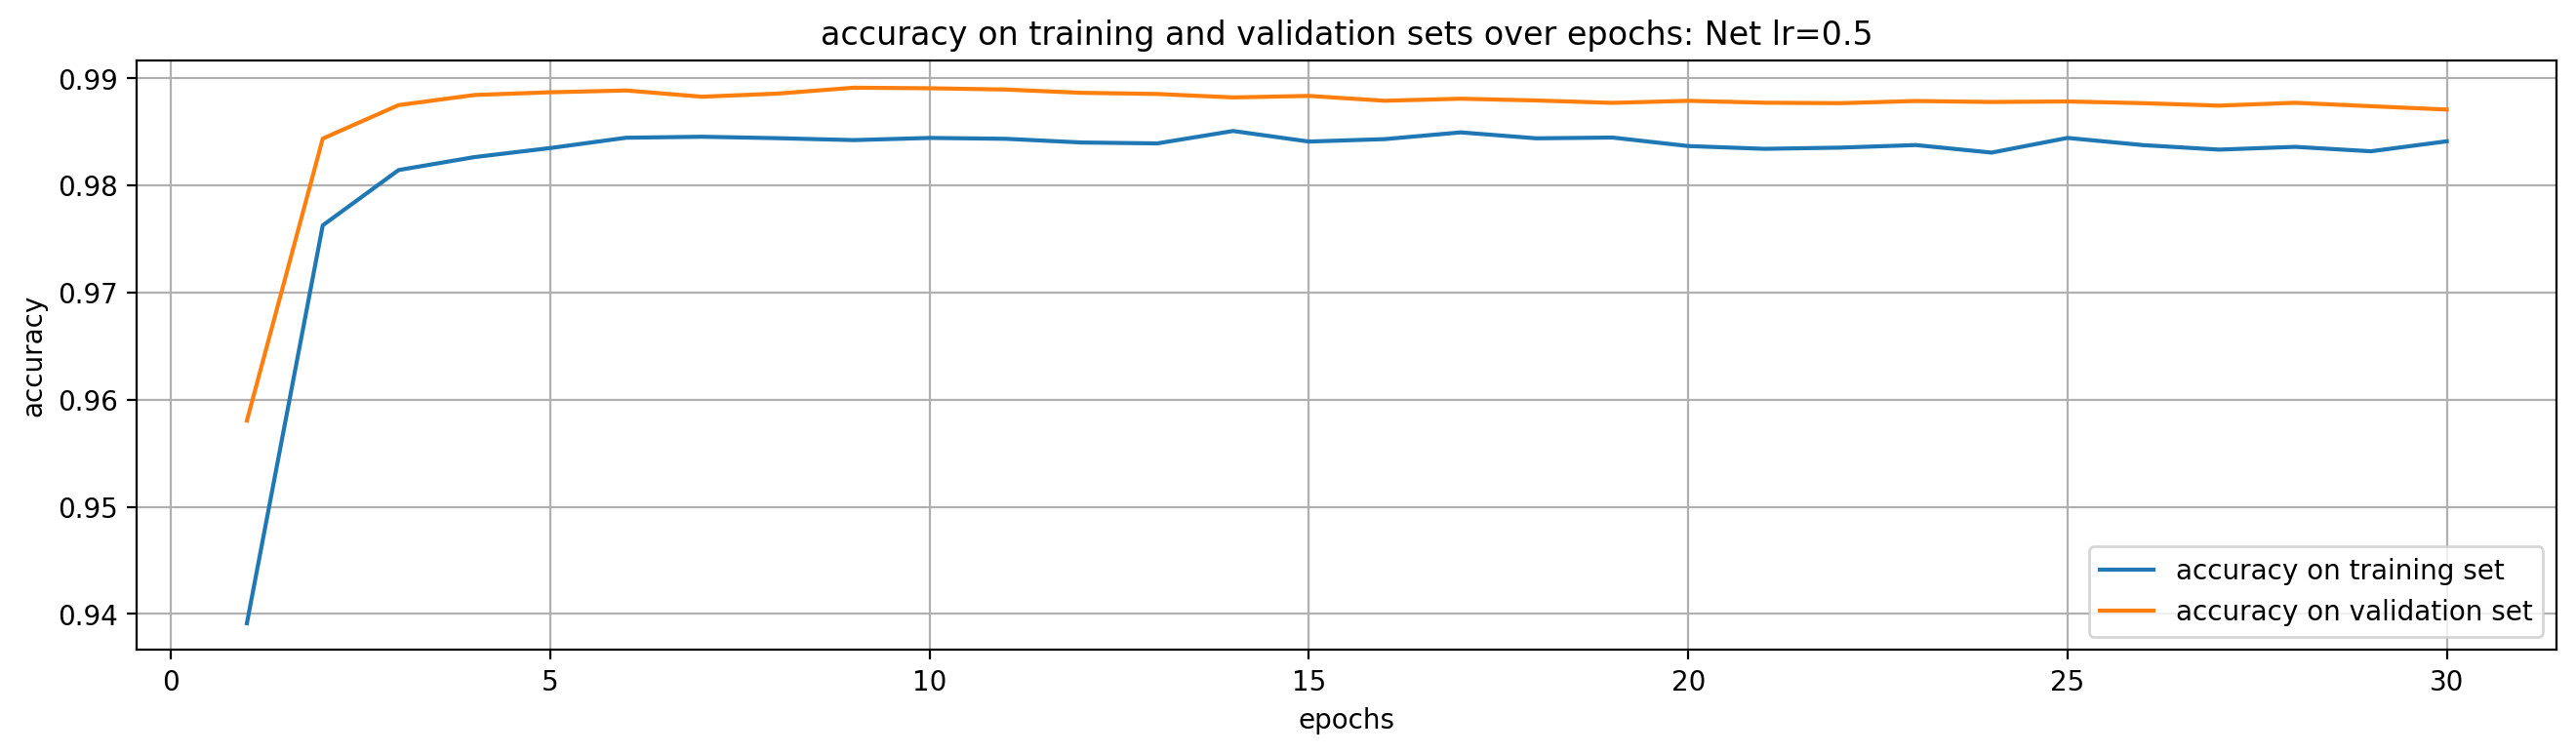

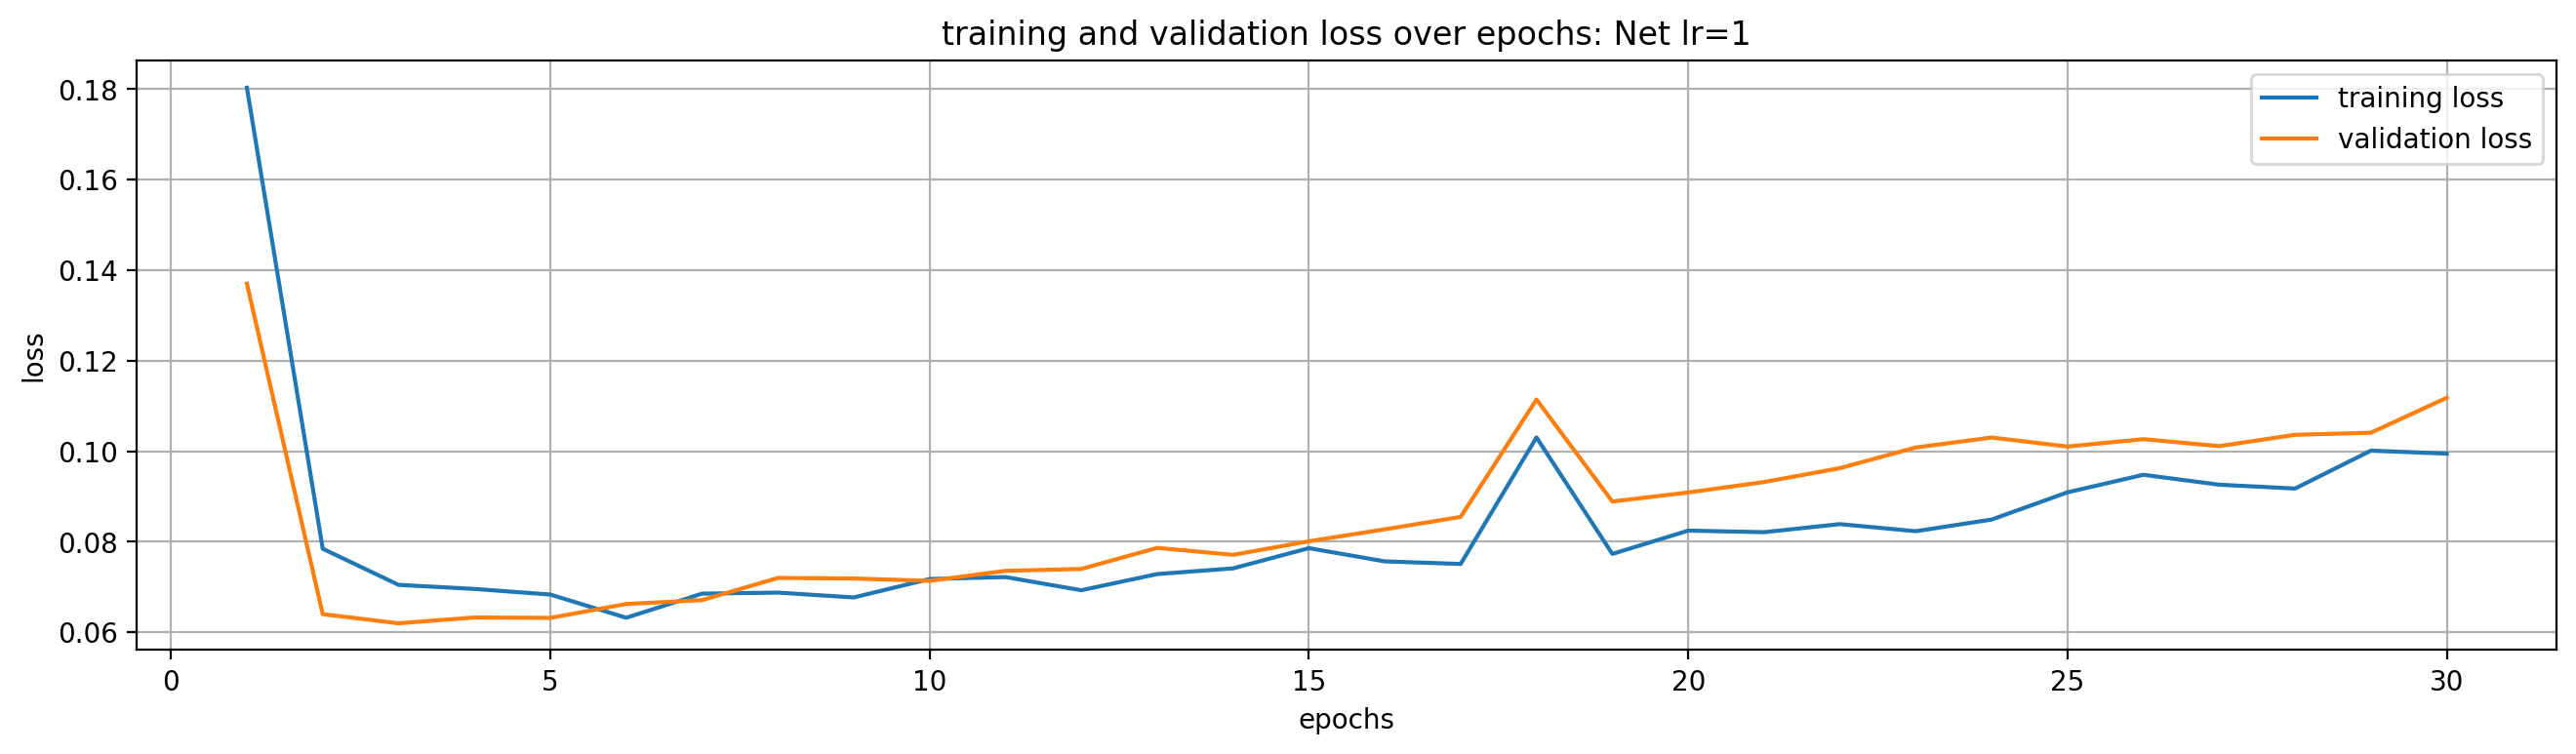

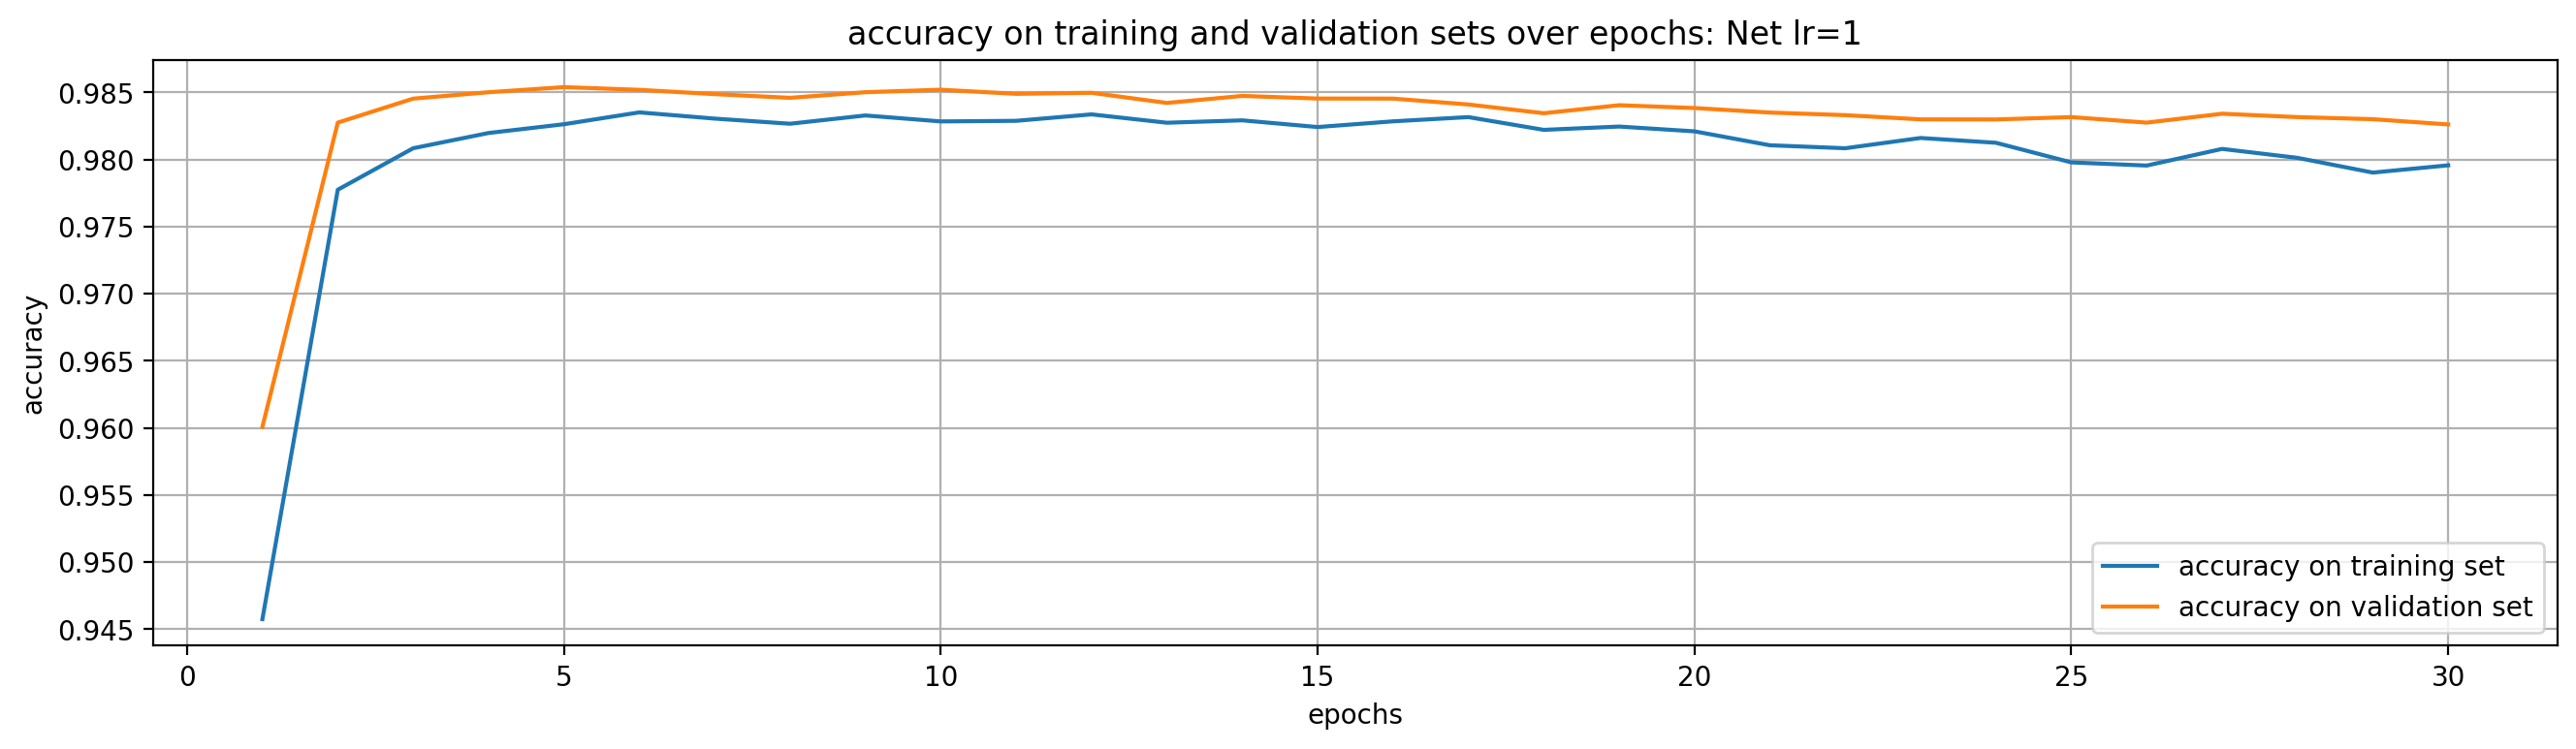

In [8]:
for r,title in zip(results, model_titles):
    display_results(r, title)

## Test metrics

Show test accuracy of selected models

In [9]:
data_loader = Data()
n_classes=10

print('evaluation on test set:')

for model, model_title in zip(models, model_titles):
    l, acc = evaluate(model, data_loader.test_loader, device)
    print(f"{model_title} : loss {l:.4f}, accuracy {acc}")
    torch.cuda.empty_cache()

evaluation on test set:
Net lr=0.5 : loss 0.0474, accuracy 0.9878
Net lr=1 : loss 0.0688, accuracy 0.9836


## Analyzis

Plot confusion matrix for two models

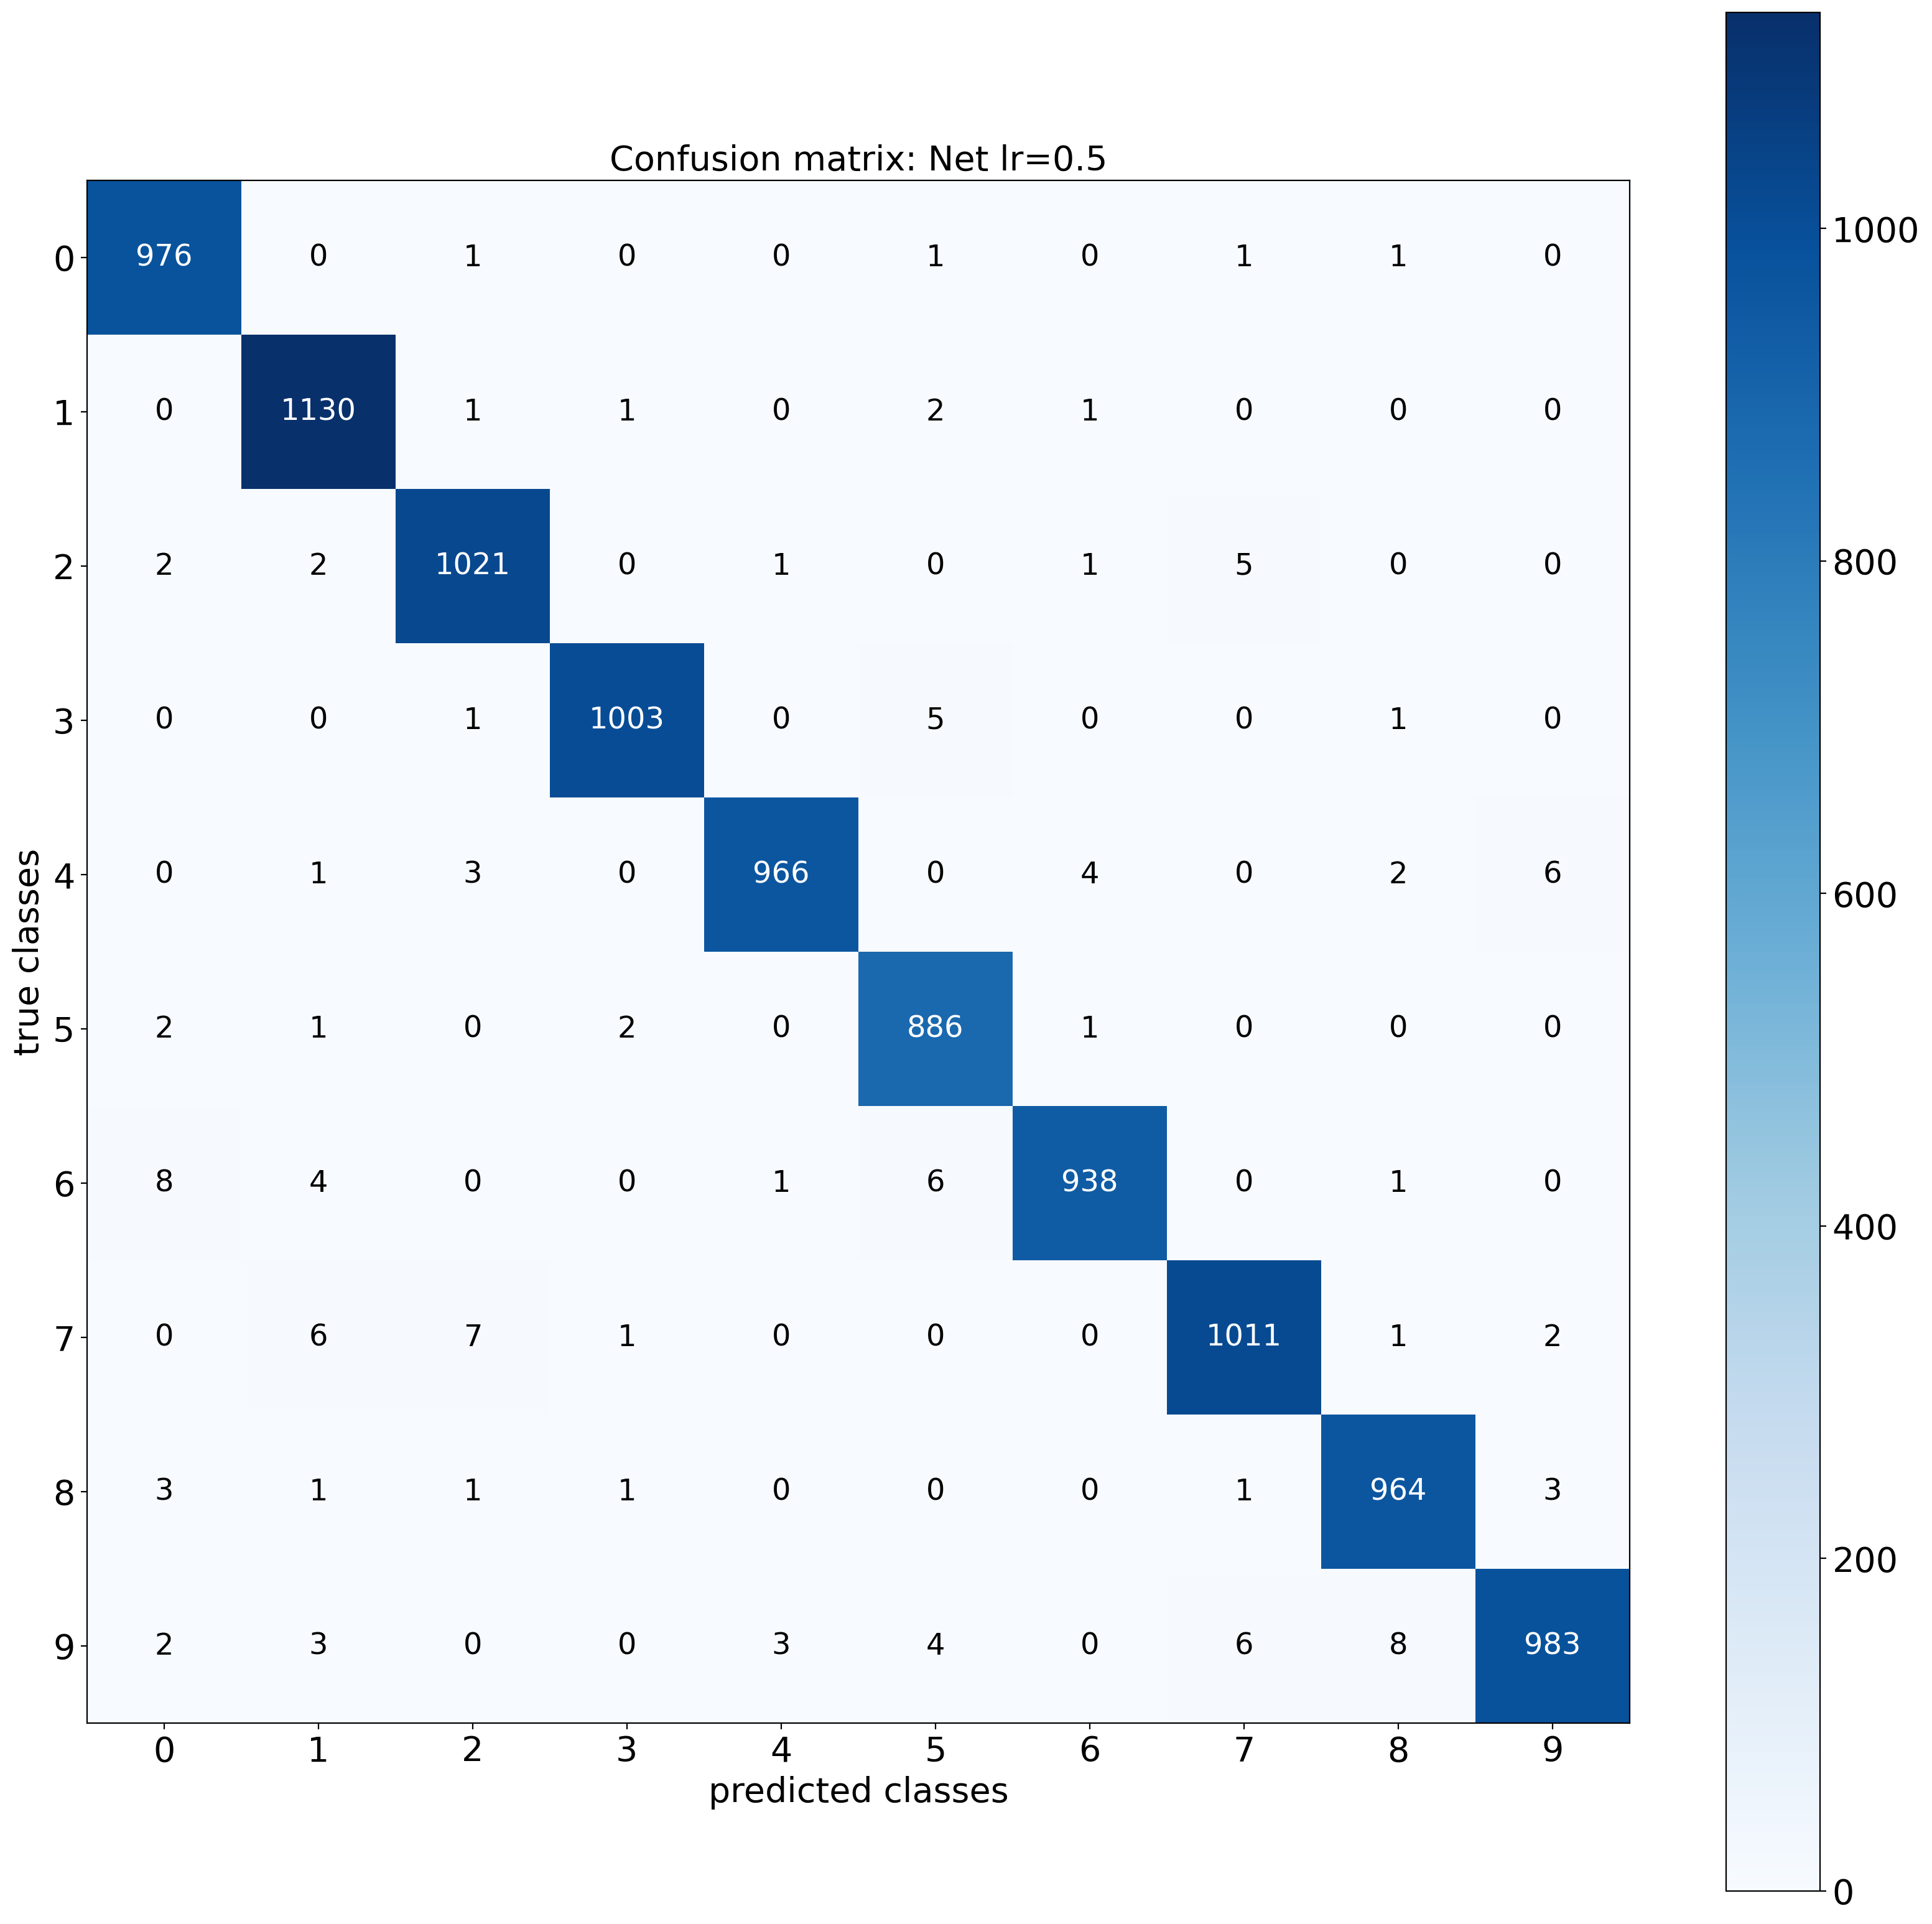

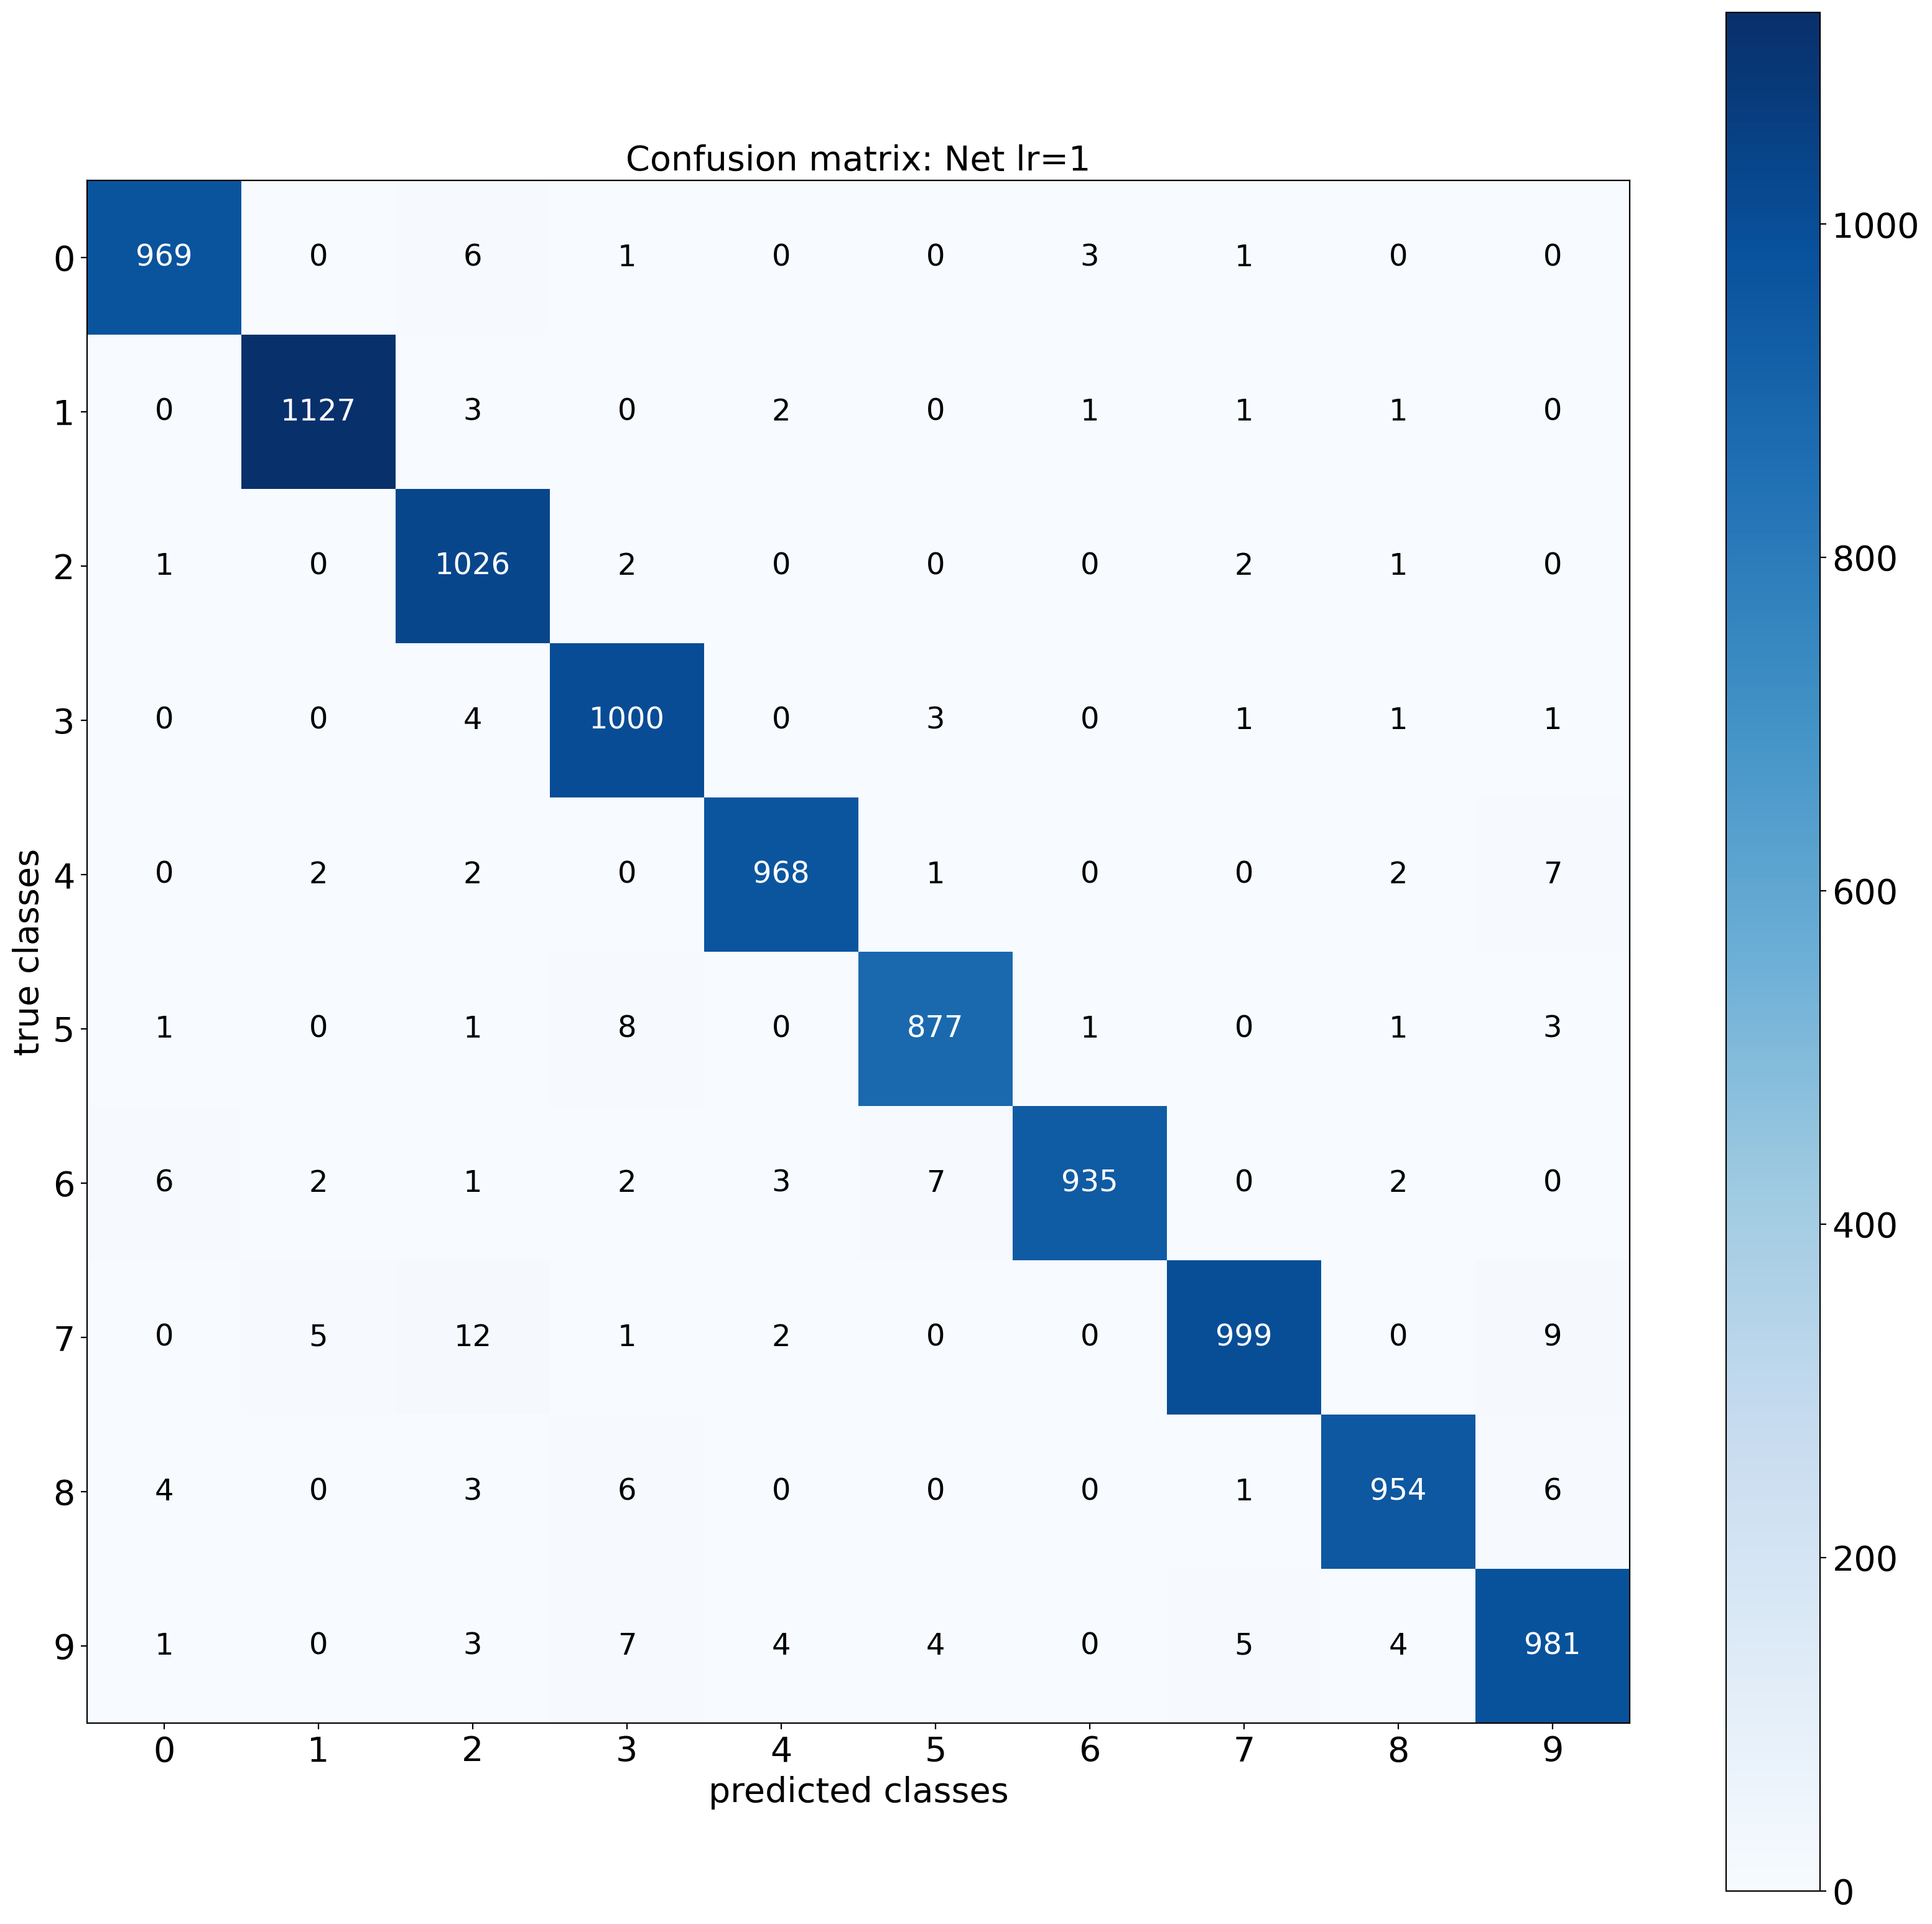

In [10]:
for model, title in zip(models, model_titles):
    C = get_confusion(model, device, data_loader, n_classes)
    plot_confusion(C, title)

Compute the networks features before the last linear layer.
Using sklearn.manifold.TSNE visualize the embedding of feature vectors for two models.

/home.nfs/hladcvla/miniconda3/envs/dle_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home.nfs/hladcvla/miniconda3/envs/dle_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home.nfs/hladcvla/miniconda3/envs/dle_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home.nfs/hladcvla/miniconda3/envs/dle_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


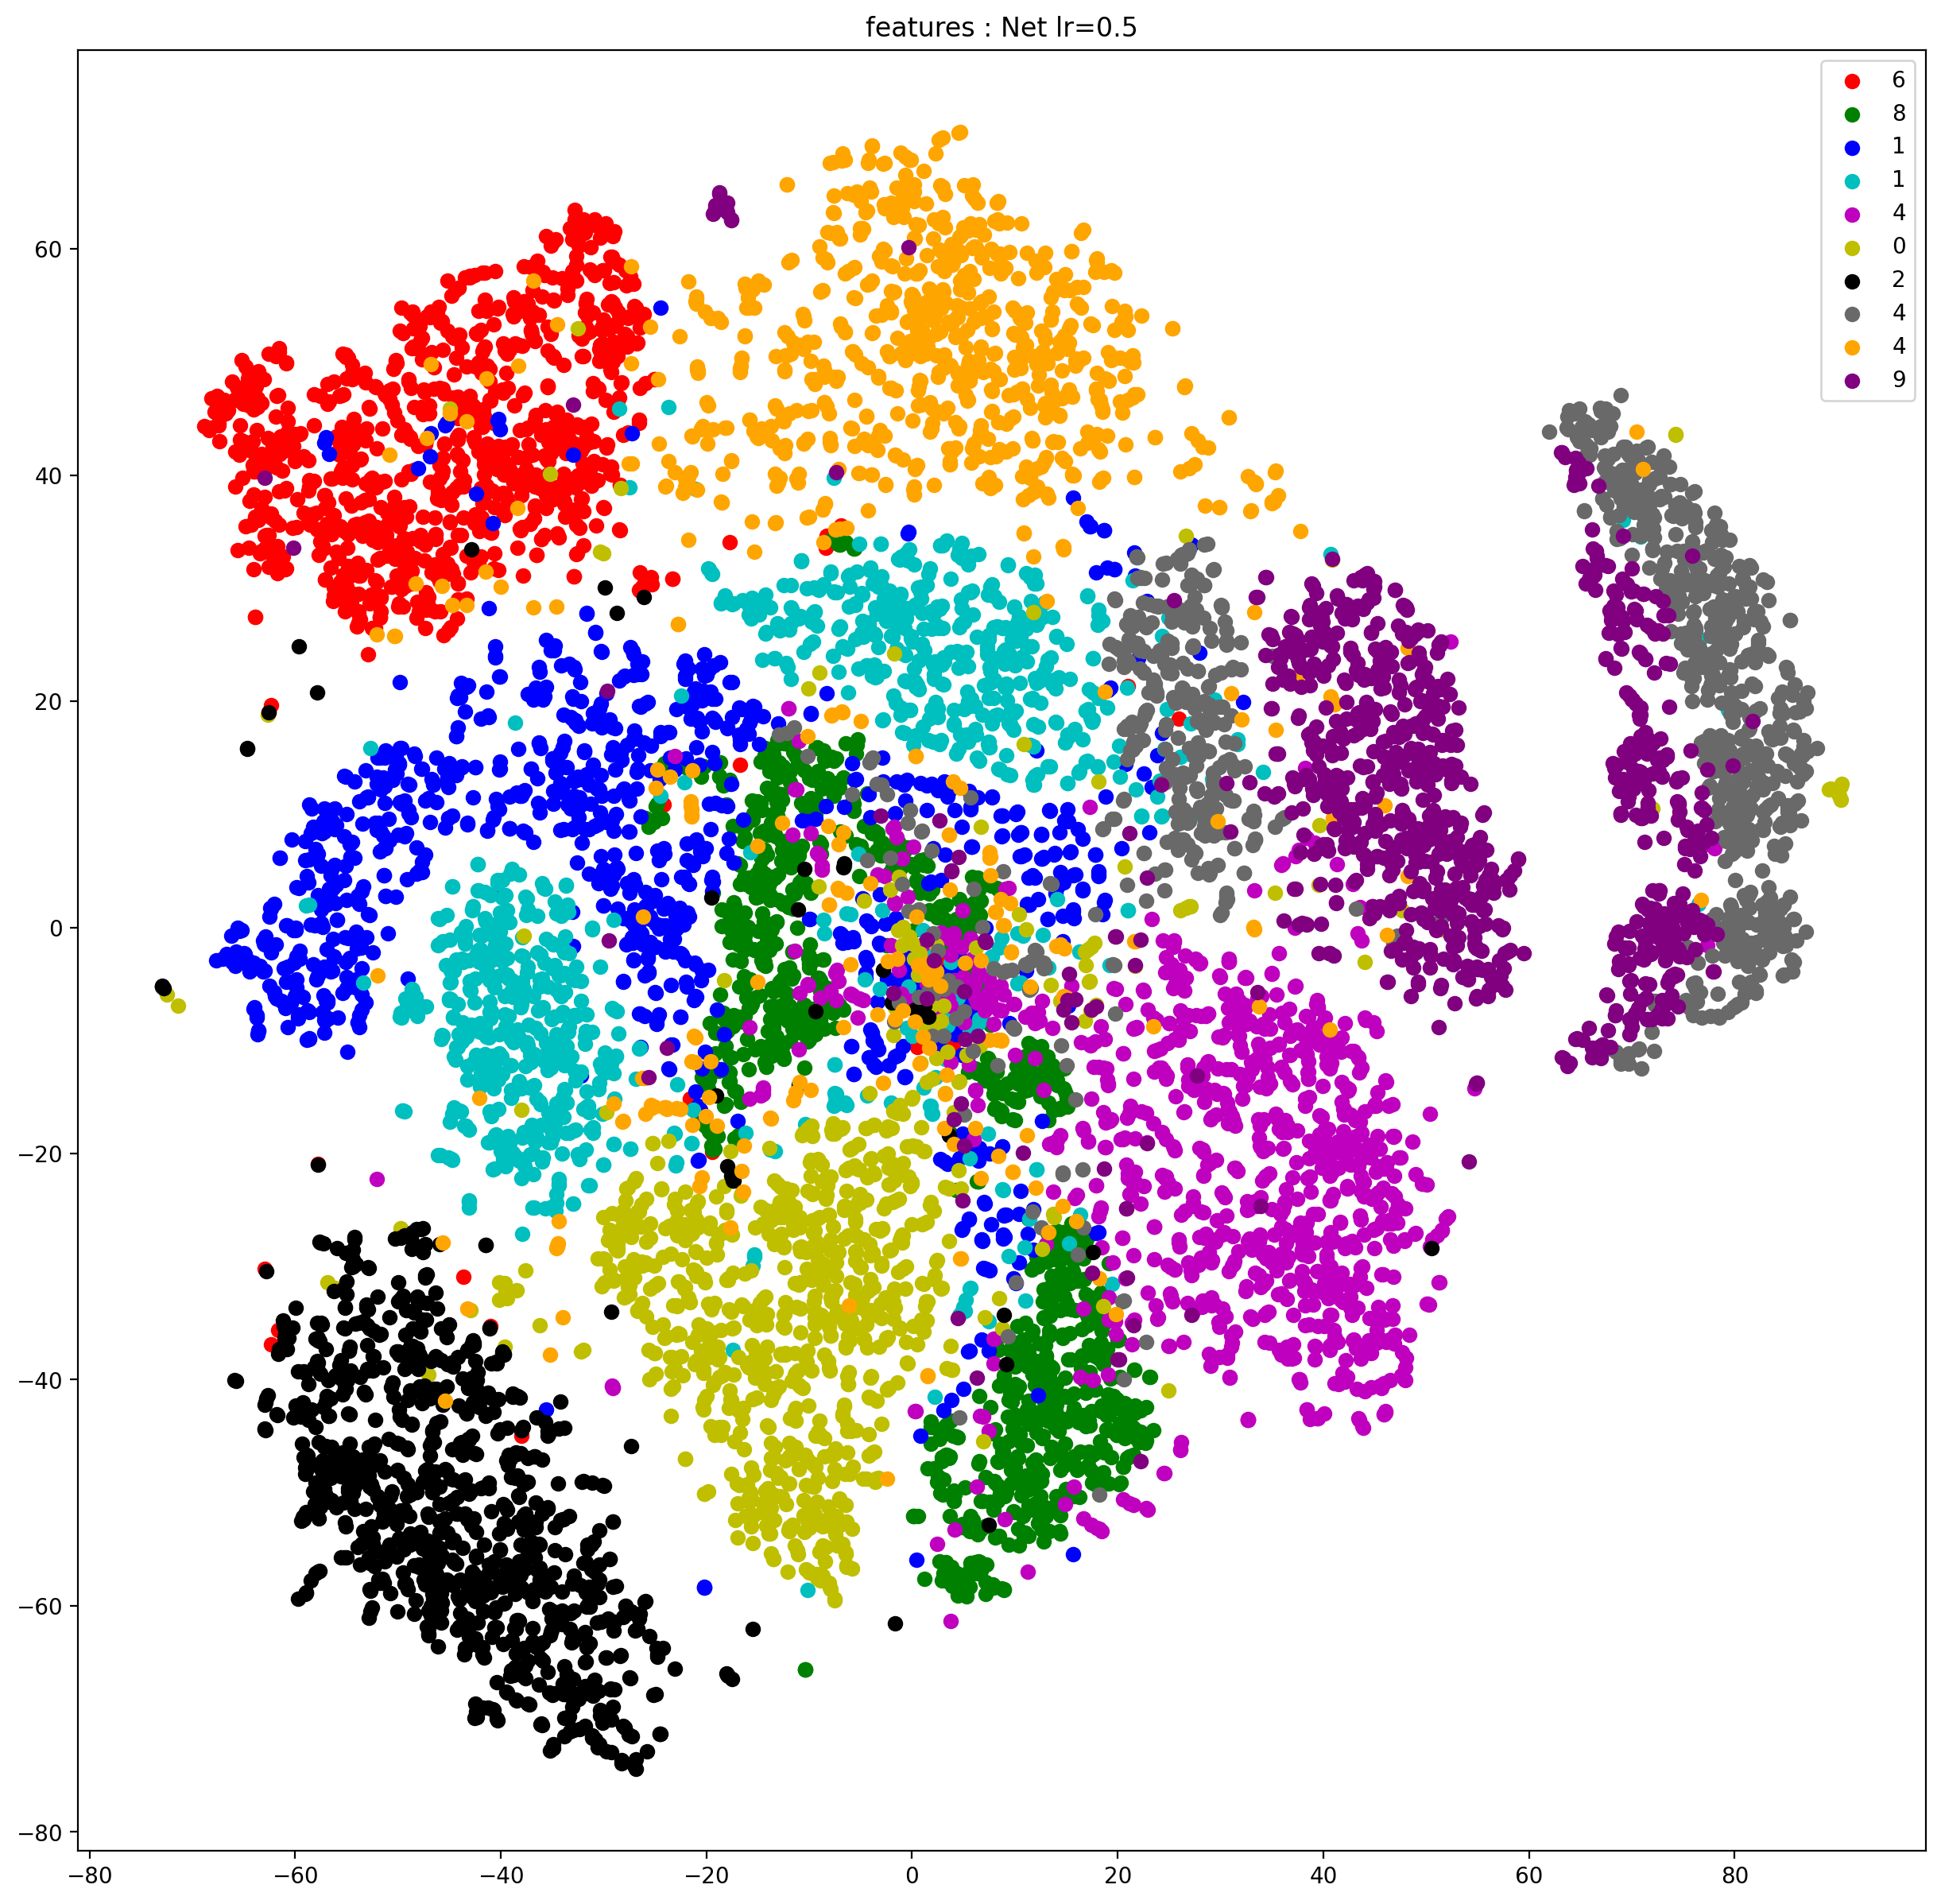

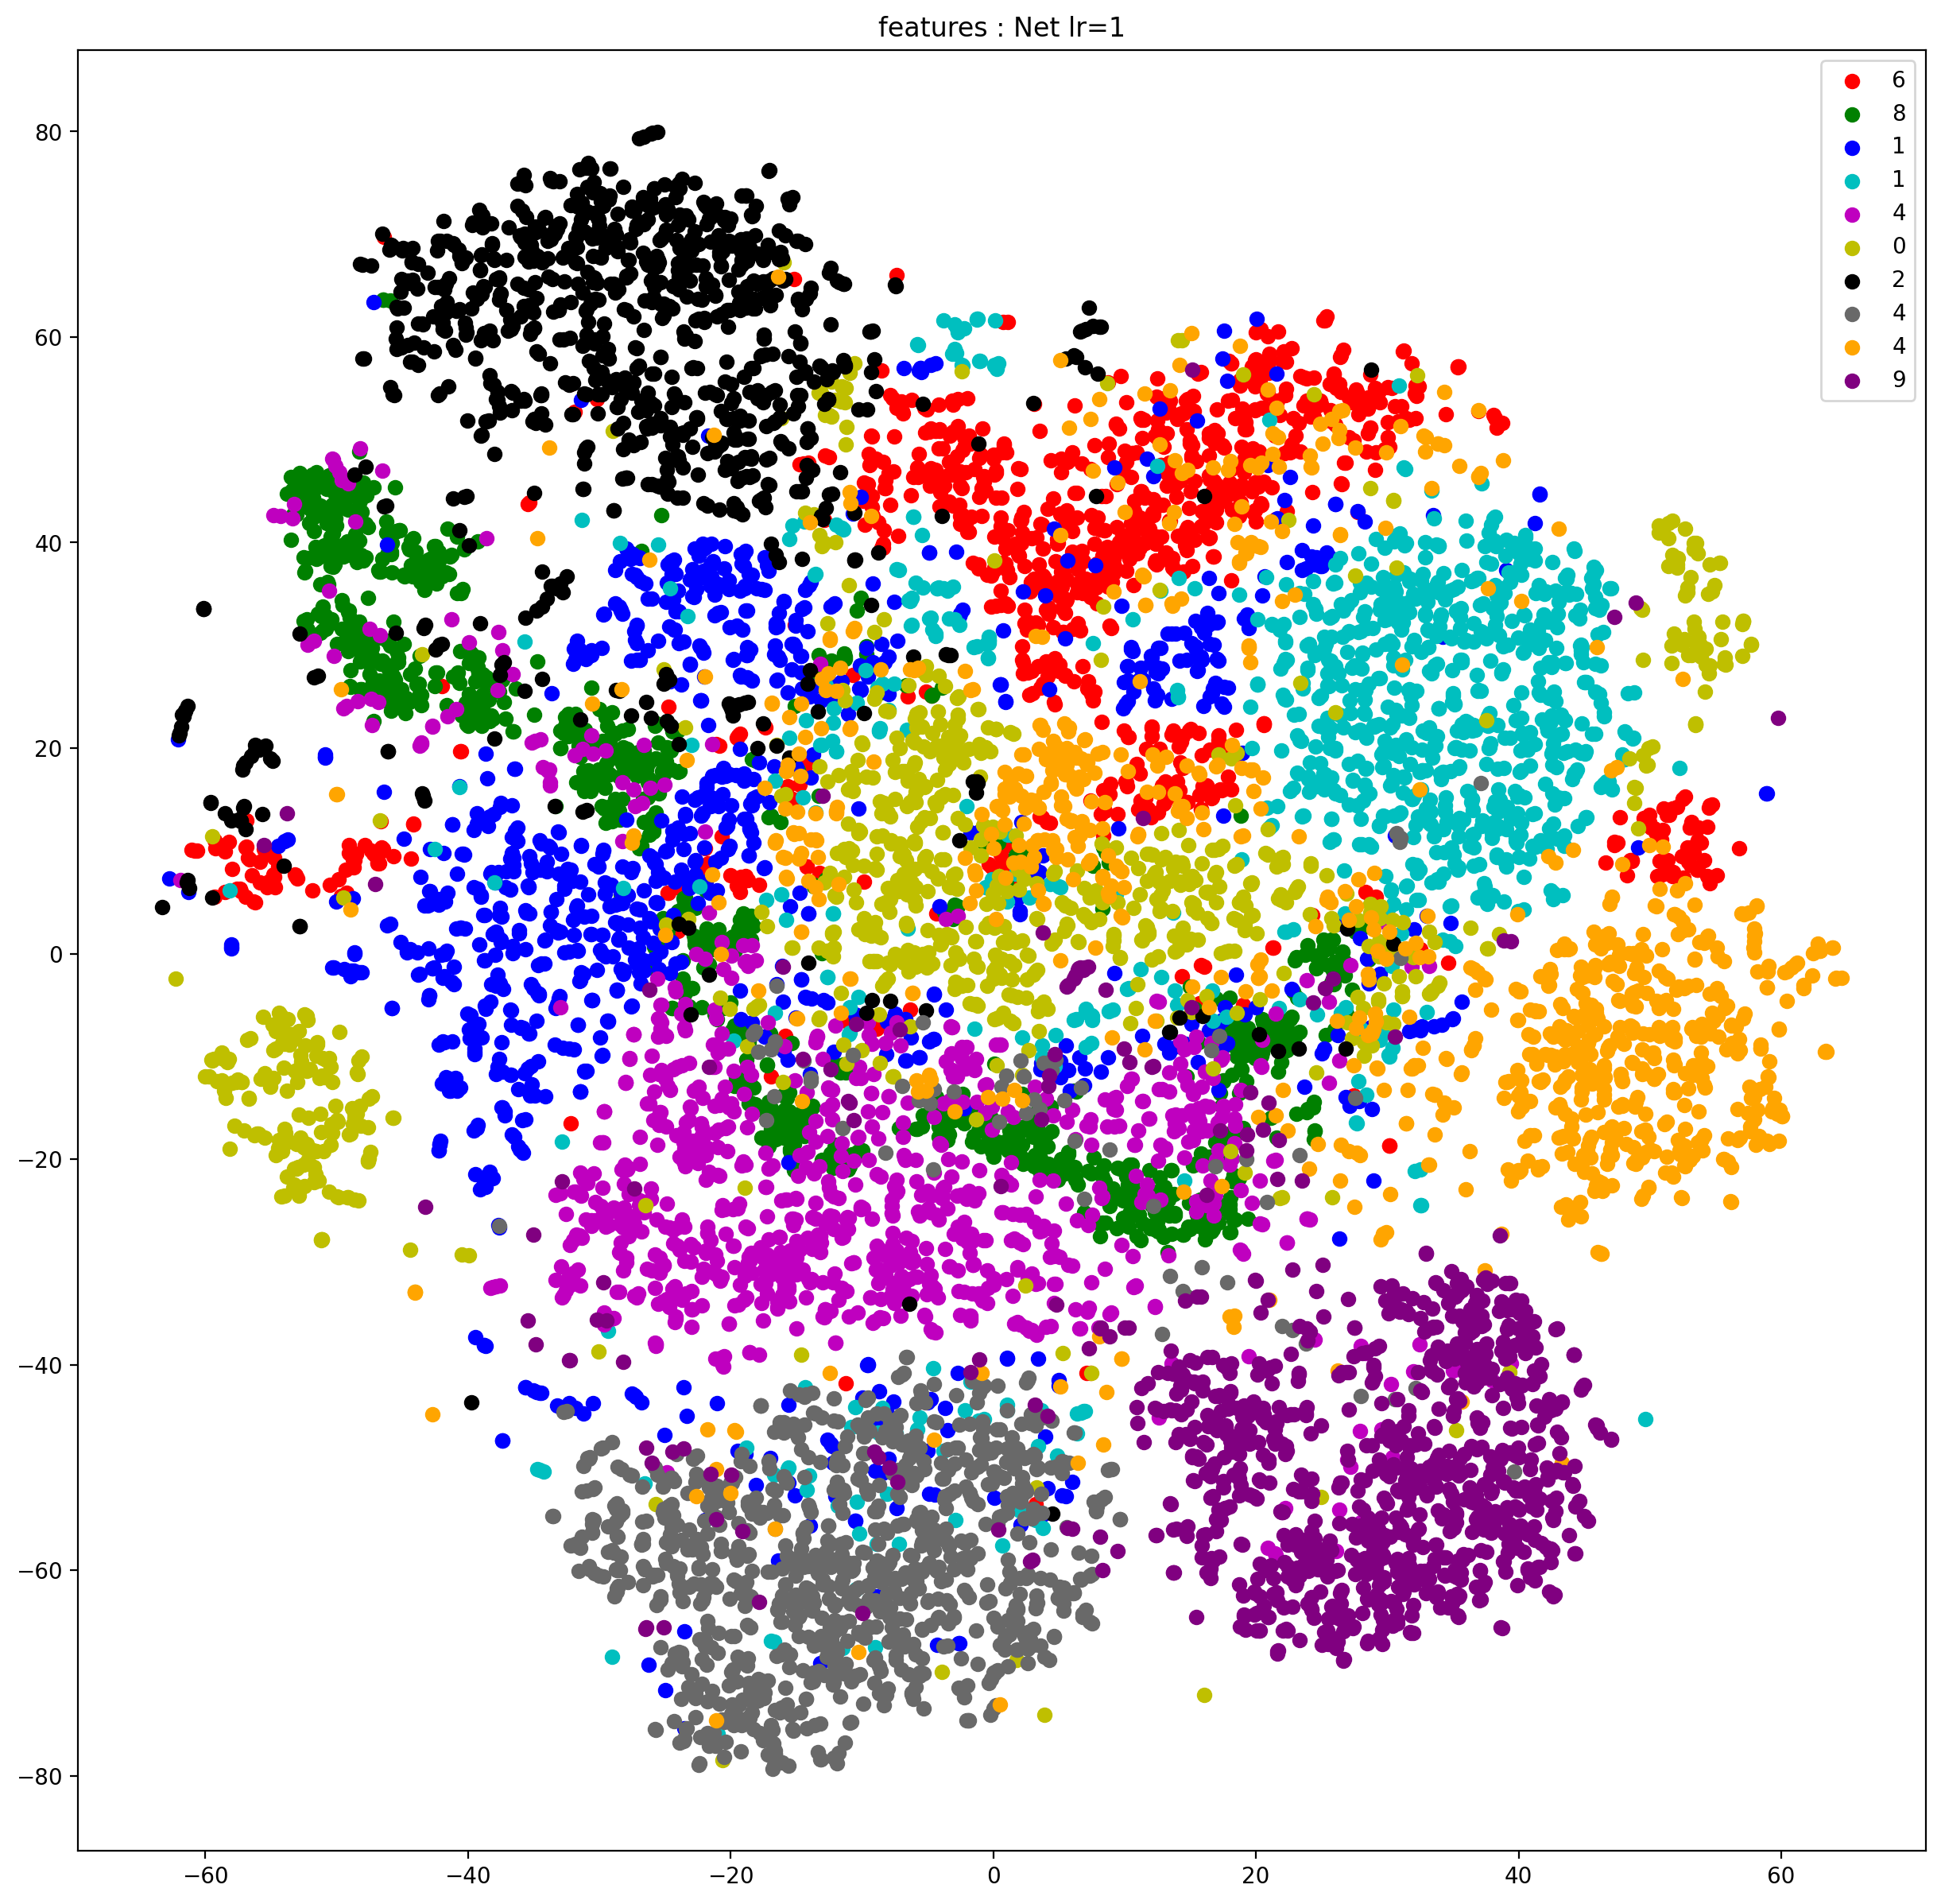

In [11]:
data,labels = next(iter(data_loader.test_loader))
labels = labels.numpy()
data = data.to(device)

for model, title in zip(models, model_titles):
    features = model.features(data).cpu().detach().numpy()
    plot_tsne(features, labels, title)

    torch.cuda.empty_cache()

Figure 1: Plot the absolute number of errors as a function of the confidence threshold

Figure 2: Plot the relative error rate of accepted points (the number or errors divided by the number of points accepted for recognition) versus the number of points rejected from recognition when the threshold is varied. 

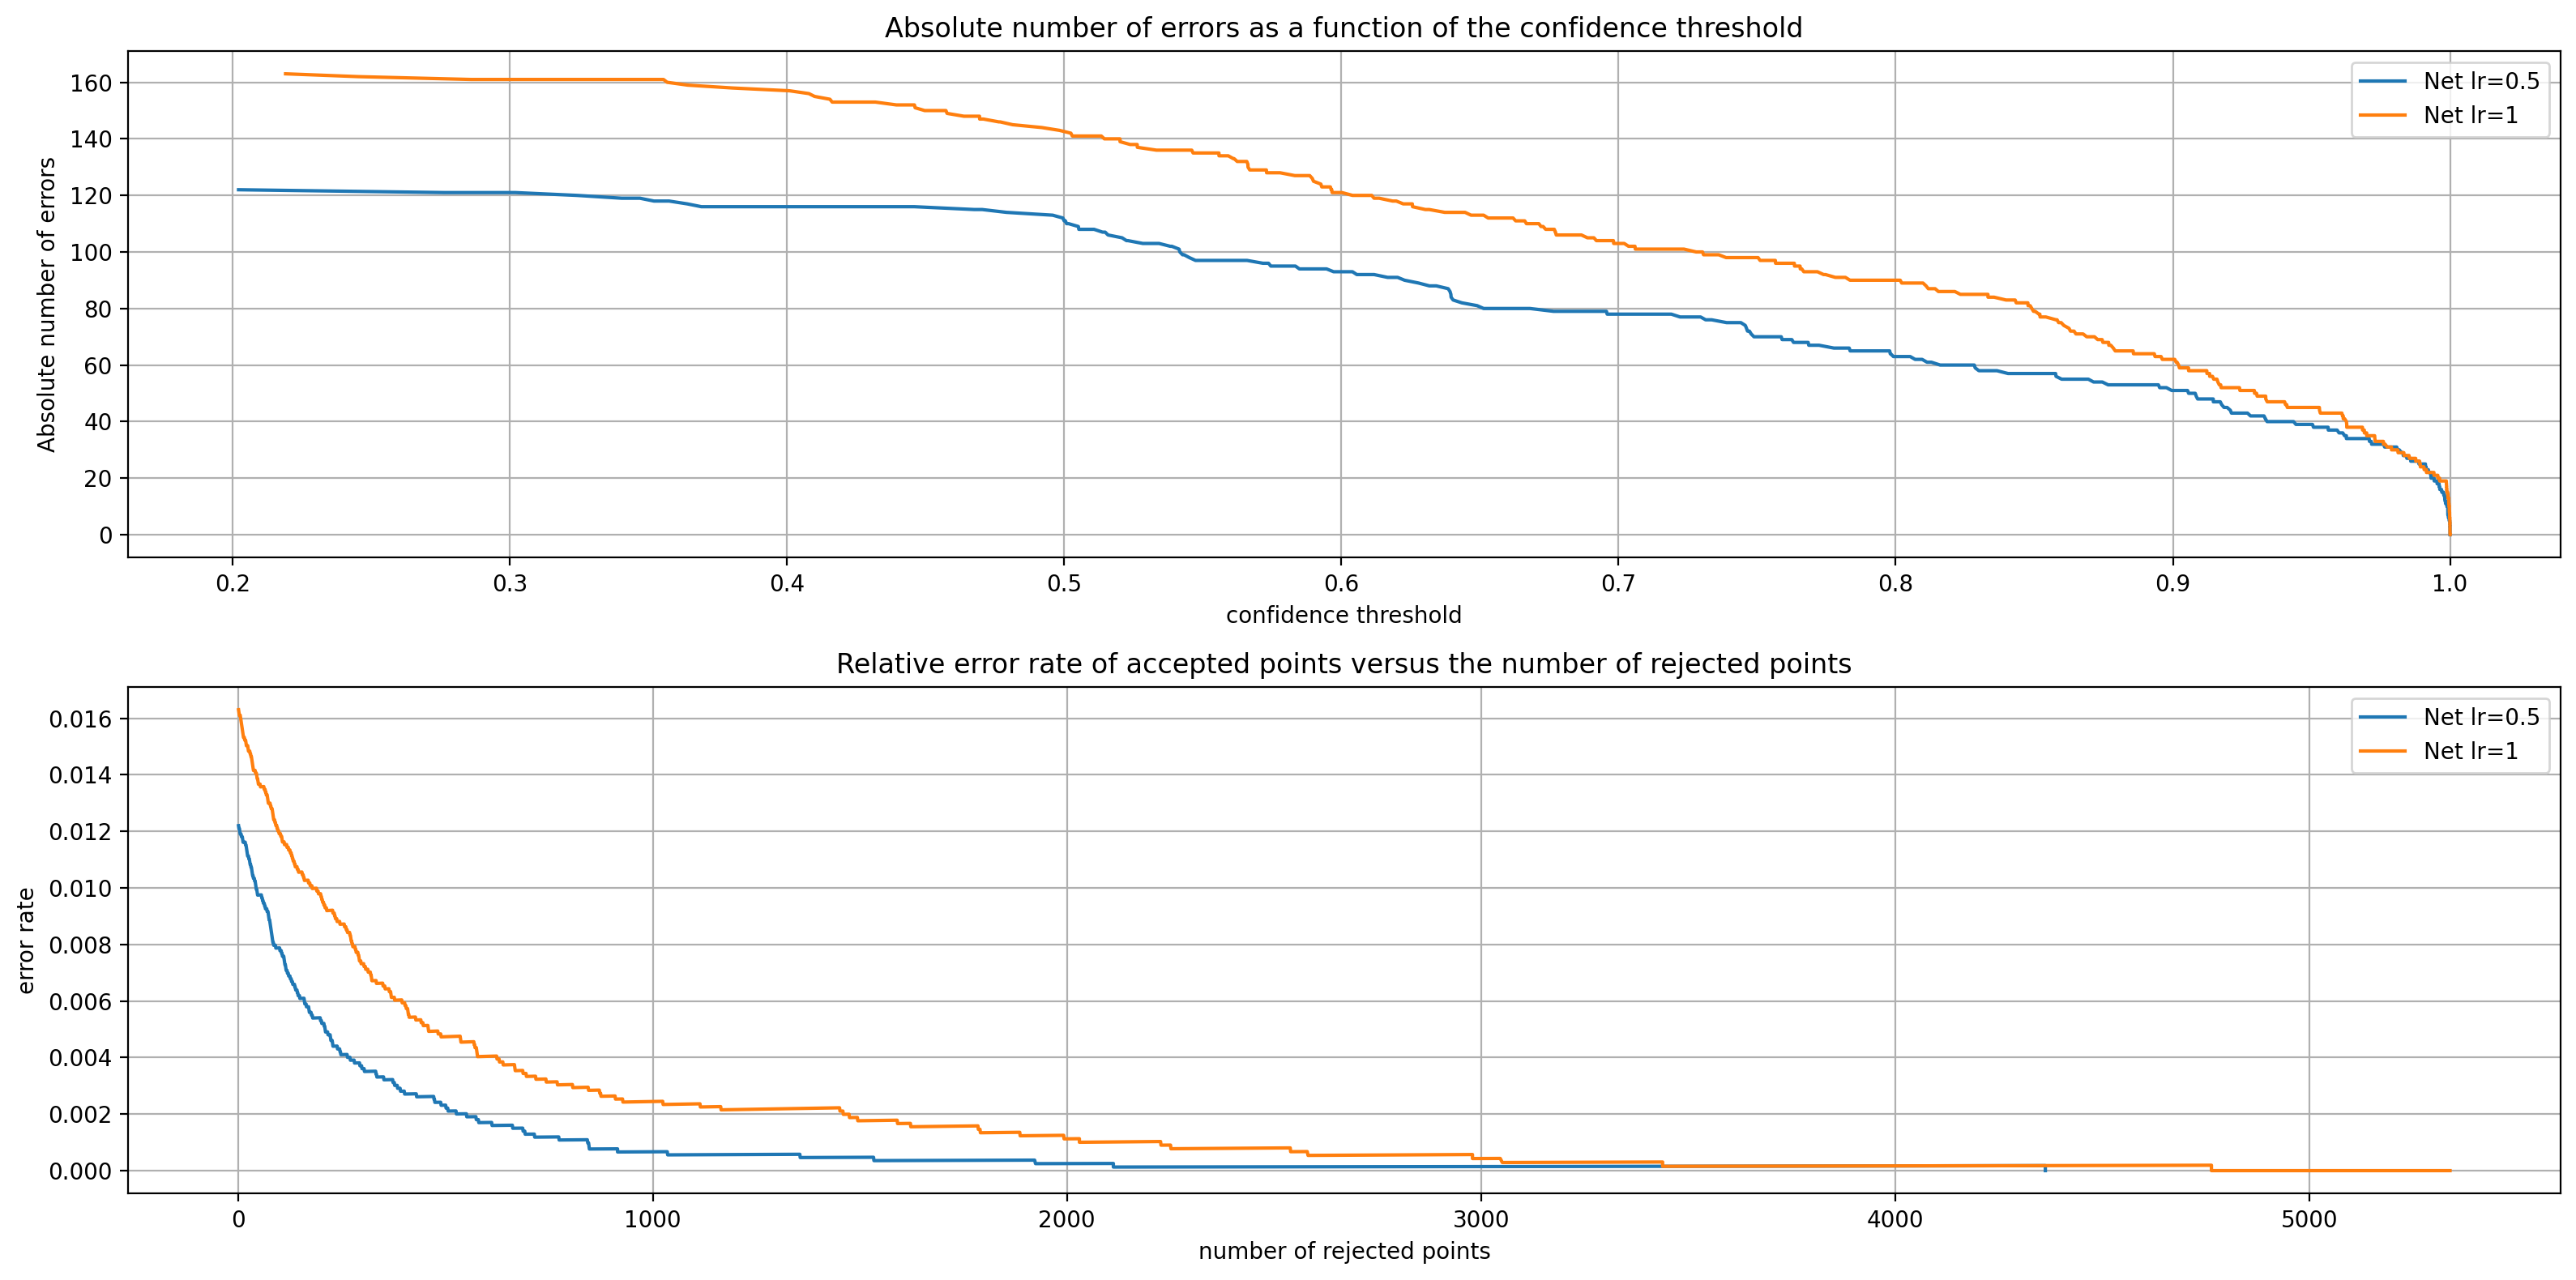

In [12]:
fig, axs = plt.subplots(2)

fig.set_size_inches(16, 4*2)
for model in models:
    pred, confidence, target = get_predictions_sorted_by_confidence(model, device, data_loader.test_loader)
    e = pred != target

    cumsum = np.cumsum(e)
    errors = np.sum(e) - cumsum
    axs[0].plot(confidence, errors)

    num_rejected_points = np.array([ np.sum(confidence < c) for c in confidence ])
    num_accepted_points = len(confidence) - num_rejected_points

    accepted_error_rate = errors/num_accepted_points

    axs[1].plot(num_rejected_points, accepted_error_rate)


axs[0].legend(model_titles)
axs[0].set_title('Absolute number of errors as a function of the confidence threshold')
axs[0].set_xlabel('confidence threshold')
axs[0].set_ylabel('Absolute number of errors')
axs[0].grid()

axs[1].legend(model_titles)
axs[1].set_title('Relative error rate of accepted points versus the number of rejected points')
axs[1].set_xlabel('number of rejected points')
axs[1].set_ylabel('error rate')
fig.tight_layout()
axs[1].grid()